# 1. Setup

In [1]:
import os, sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

print("CWD:", os.getcwd())
print("PYTHON:", sys.executable)


# Determine project root in both scripts and notebooks
try:
    BASE_DIR = Path(__file__).resolve().parents[2]  # for scripts
except NameError:
    BASE_DIR = Path.cwd().parents[1]                # for notebooks

DATA_DIR = BASE_DIR / "Data"

# load datasets
weather = pd.read_csv(DATA_DIR / "boston_weather.csv", skiprows=3)
pollution = pd.read_csv(DATA_DIR / "boston_pollutants.csv")
pollen = pd.read_csv(DATA_DIR / "boston_pollen.csv")

# parse date columns
weather['time'] = pd.to_datetime(weather['time'])
pollution['date'] = pd.to_datetime(pollution['date'])
pollen['Date'] = pd.to_datetime(pollen['Date'])

# rename and merge
weather.rename(columns={'time': 'Date'}, inplace=True)
pollution.rename(columns={'date': 'Date'}, inplace=True)

merged = (
    weather
    .merge(pollution, on='Date', how='inner')
    .merge(pollen, on='Date', how='inner')
)

merged.info()

# filter for pollen season (March through October)
merged = merged[merged['Date'].dt.month.isin(range(3, 11))]


# select relevant numeric columns
cols = [
    # Weather (all numeric)
    'weather_code (wmo code)',
    'temperature_2m_mean (°C)',
    'apparent_temperature_mean (°C)',
    'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)',
    'wind_speed_10m_max (km/h)',
    'wind_direction_10m_dominant (°)',

    # Pollution
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2',
    'AQI', 'num_pollutants_available',

    # Pollen
    'Tree', 'Grass', 'Weed', 'Ragweed', 'Total_Pollen'
]

numeric = merged[[c for c in cols if c in merged.columns]]
corr = numeric.corr()


# ------------------------------
# Pollen statistics
# ------------------------------
pollen_cols = ['Tree', 'Grass', 'Weed', 'Ragweed', 'Total_Pollen']

for col in pollen_cols:
    if col in merged.columns:
        print(f"{col} range: {merged[col].min()} - {merged[col].max()} | mean: {merged[col].mean():.2f}")


CWD: C:\Users\BigBo\Documents\cs506\boston-aqi-prediction\Models\pollen_models
PYTHON: C:\Users\BigBo\Documents\cs506\boston-aqi-prediction\venv\Scripts\python.exe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             2176 non-null   datetime64[ns]
 1   temperature_2m_mean (°C)         2176 non-null   float64       
 2   precipitation_sum (mm)           2176 non-null   float64       
 3   apparent_temperature_mean (°C)   2176 non-null   float64       
 4   wind_gusts_10m_max (km/h)        2176 non-null   float64       
 5   wind_speed_10m_max (km/h)        2176 non-null   float64       
 6   wind_direction_10m_dominant (°)  2176 non-null   int64         
 7   date_local                       2176 non-null   object        
 8   PM2.5                            2

Tree range: 0.0 - 2926.0 | mean: 97.98
Grass range: 0.0 - 349.0 | mean: 6.77
Weed range: 0.0 - 267.0 | mean: 9.99
Ragweed range: 0.0 - 558.0 | mean: 6.33
Total_Pollen range: 0.0 - 2926.0 | mean: 111.36


# 2. Linear Regression Model - Not Very Good


2009-07-20 00:00:00 2024-10-13 00:00:00
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024]
(38, 35)
MAE: 103.20925857420845
RMSE: 223.53722740526962
R²: 0.106199894287623
                            feature  coefficient
12                           AQI_O3   162.269590
1    apparent_temperature_mean (°C)  -119.612509
7                                O3  -115.686245
6                             PM2.5   -90.900323
0          temperature_2m_mean (°C)    86.202528
10                              SO2   -63.643843
16                              AQI    60.205373
15                          AQI_SO2    40.289147
11                        AQI_PM2.5    30.757413
5   wind_direction_10m_dominant (°)   -16.347806
3         wind_gusts_10m_max (km/h)   -16.045528
8                                CO   -15.760963
13                           AQI_CO     7.272991
4         wind_speed_10m_max (km/h)     7.026413
9                               NO2     6.679258
2            

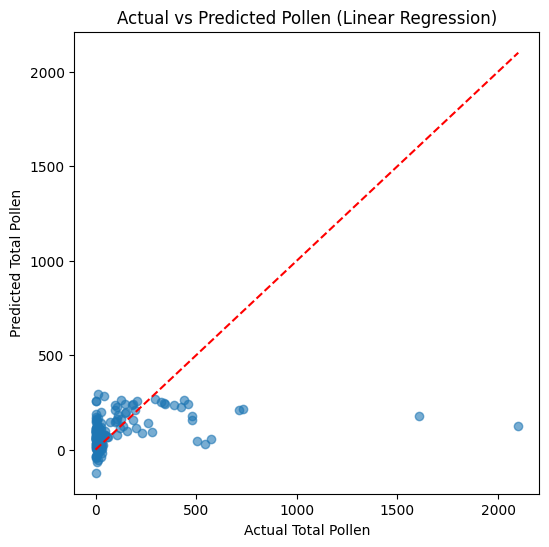

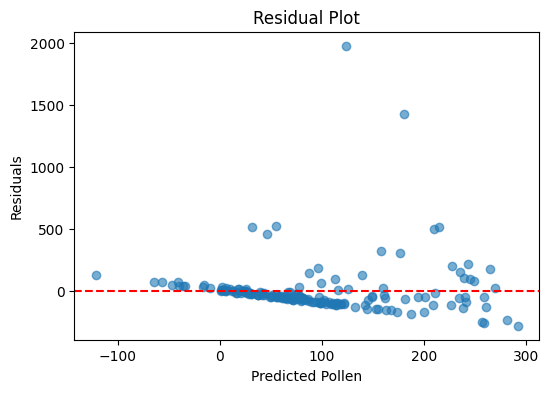

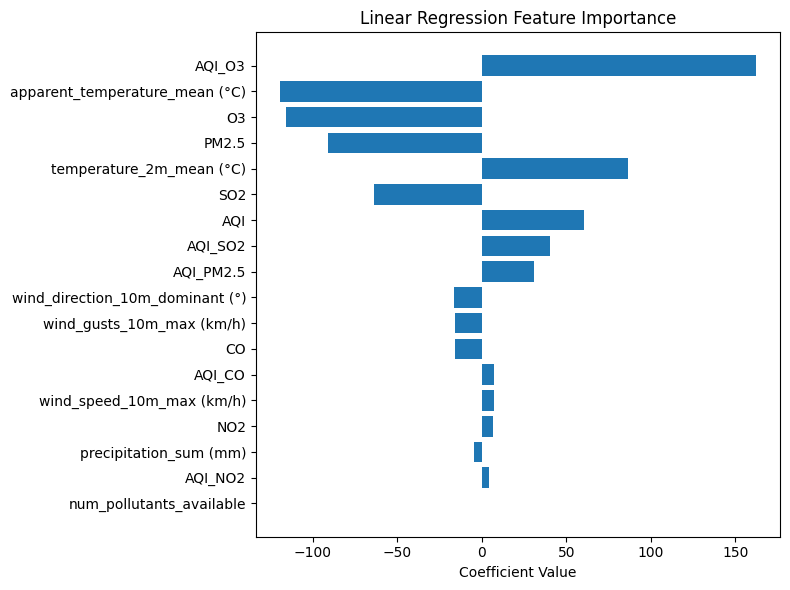

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# use the merged dataframe
df = merged.copy()

# drop rows with missing values in predictors or target
df = df.dropna(subset=numeric.columns)

# ------------------------------
# 1. Select target + features
# ------------------------------
target = "Total_Pollen"   
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"] # remove pollen related variables 
features = [c for c in numeric.columns if c not in remove_cols]

# ------------------------------
# 2. Split data by date (all 2024 as test)
# ------------------------------
df = df.sort_values("Date")  # make sure dates are in order

train_df = df[df['Year'] < 2023]   # all years before 2024 for training
test_df = df[df['Year'] >= 2023]   # all of 2024 for testing

print(df['Date'].min(), df['Date'].max())       # check the full date range
print(df['Date'].dt.year.unique())             # see which years exist
print(df[df['Date'].dt.year == 2024].shape)    # see how many rows for 2024

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# ------------------------------
# 3. Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 4. Train linear regression
# ------------------------------
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ------------------------------
# 5. Model evaluation
# ------------------------------
y_pred = model.predict(X_test_scaled)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# ------------------------------
# 6. Coefficients (feature importance for linear regression)
# ------------------------------
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

print(coef_df)

# ------------------------------
# 7. Visualize results
# ------------------------------

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted Pollen (Linear Regression)")
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Feature importance (coefficients)
plt.figure(figsize=(8,6))
coef_df_sorted = coef_df.sort_values("coefficient", key=abs)
plt.barh(coef_df_sorted["feature"], coef_df_sorted["coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Feature Importance")
plt.tight_layout()
plt.show()


# 3. Random Forest

Using numeric cols (detected): ['temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)', 'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'PM2.5', 'O3', 'CO', 'NO2', 'SO2', 'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI', 'num_pollutants_available']
Found rolling columns: ['temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'PM2.5', 'O3', 'CO', 'NO2', 'SO2', 'AQI', 'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'wind_speed_10m_max (km/h)']
Spike threshold (computed on training period): 381.23212608760474
Final feature count: 85
Some features: ['temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)', 'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'PM2.5', 'O3', 'CO', 'NO2', 'SO2', 'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI', 'num_pollutants_available', 'lag1', 'lag2', 'lag3', 'pollen_3day',


Training Metrics:
MAE: 45.07657801535846
RMSE: 160.7765473241748
R²: 0.6496515840299324

Test Metrics:
MAE: 85.54952207070137
RMSE: 242.6083857505997
R²: 0.3340525791891802

Top 30 features:
                                    feature  importance
21                             pollen_3day    0.597140
18                                    lag1    0.066549
22                             pollen_7day    0.050566
23                                 sin_day    0.030943
2                   precipitation_sum (mm)    0.018859
24                                 cos_day    0.016156
0                 temperature_2m_mean (°C)    0.009141
82          temperature_2m_mean (°C)_x_AQI    0.007995
19                                    lag2    0.007304
5          wind_direction_10m_dominant (°)    0.006238
26      temperature_2m_mean (°C)_weighted3    0.005495
7                                       O3    0.005327
1           apparent_temperature_mean (°C)    0.005144
83  apparent_temperature_mean (°C)_x_

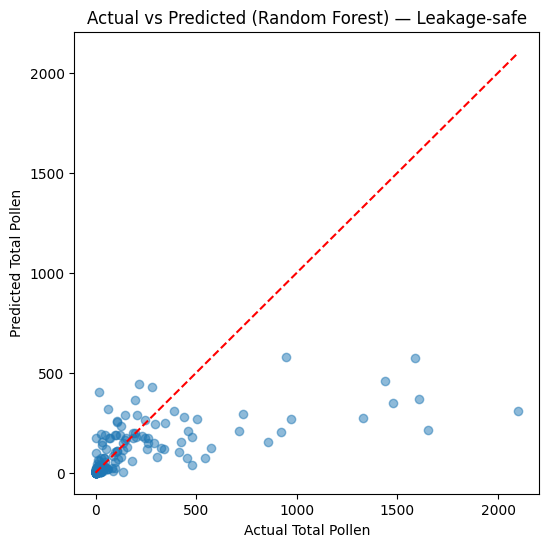

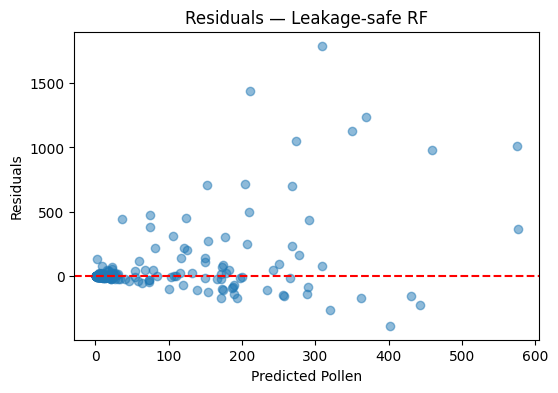

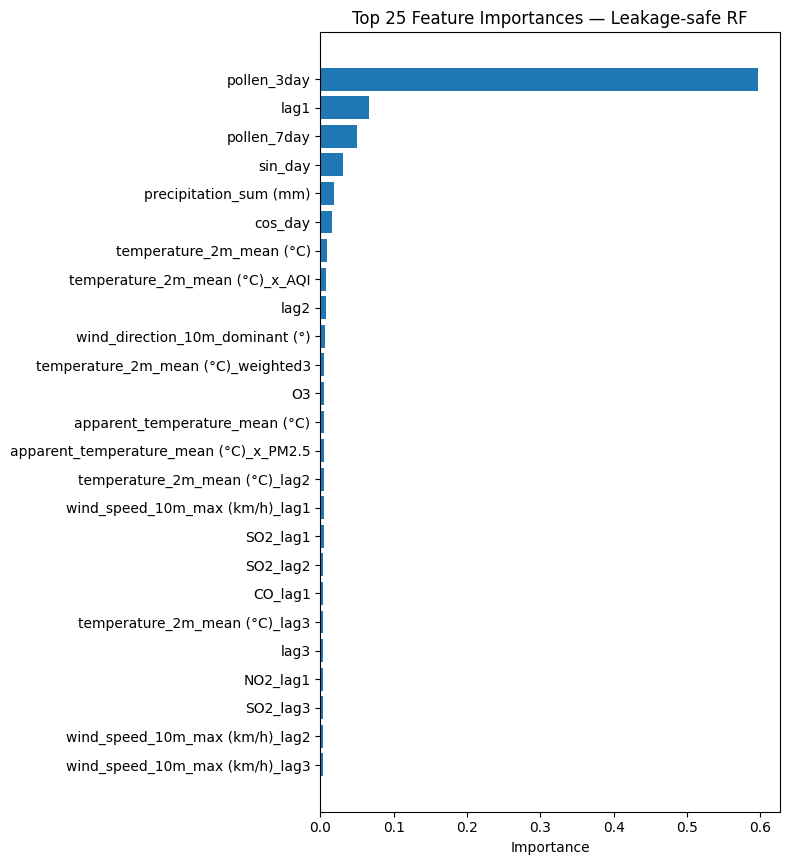

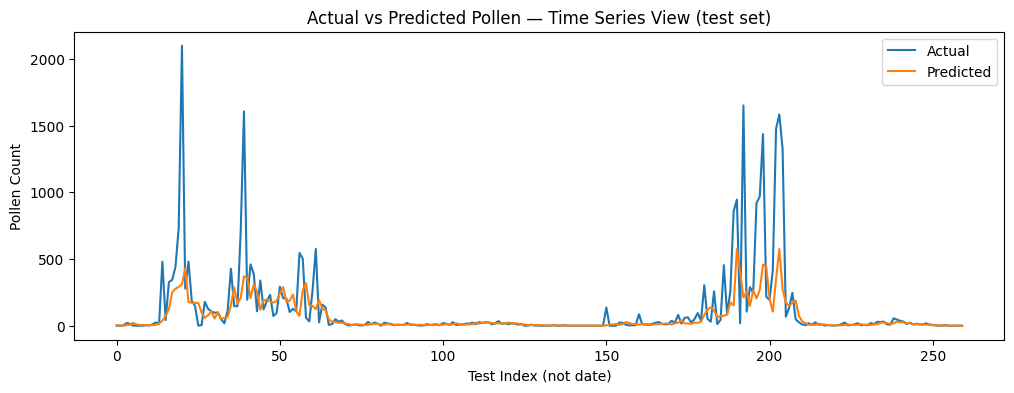

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# CONFIG
# -------------------------
YEAR_SPLIT = 2023

# -------------------------
# 0. Basic checks and setup
# -------------------------
try:
    df = merged.copy()
    
except NameError as e:
    raise RuntimeError("DataFrame `merged` not found in environment. Please load it and try again.") from e

# Ensure Date column exists and is datetime
if "Date" not in df.columns:
    raise RuntimeError("`merged` must contain a 'Date' column.")
df = df.sort_values("Date").reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

if df["Date"].isna().any():
    raise RuntimeError("Some 'Date' values could not be parsed as datetime. Fix or drop them before running.")

# Basic target check
if "Total_Pollen" not in df.columns:
    raise RuntimeError("`merged` must contain 'Total_Pollen' as the target column.")

# Create Year for splitting
df["Year"] = df["Date"].dt.year

# -------------------------
# 1. Numeric columns detection (robust)
# -------------------------
# Prefer user's `numeric` if present and appears valid
numeric_cols = []
try:
    # numeric could be a DataFrame or Index-like
    if 'numeric' in globals() or 'numeric' in locals():
        # try to coerce to list of names
        try:
            numeric_cols = list(numeric.columns)
        except Exception:
            numeric_cols = list(numeric)
except Exception:
    numeric_cols = []

# Fallback: infer numeric-like columns from df (exclude target/date/year and obviously non-feature names)
if not numeric_cols:
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Remove excluded technical columns if present
exclude_if_present = {"Total_Pollen", "Tree", "Grass", "Weed", "Ragweed", "Date", "Year"}
numeric_cols = [c for c in numeric_cols if c in df.columns and c not in exclude_if_present]

print(f"Using numeric cols (detected): {numeric_cols[:20]}{'...' if len(numeric_cols)>20 else ''}")

# Coerce detected numeric cols to numeric safely
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# -------------------------
# 2. Safe basic engineered features (only past info)
# -------------------------
# Target lags and rolling on shifted series (shift first, then rolling)
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)

# Past-only rolling means (shift before rolling)
df["pollen_3day"] = df["Total_Pollen"].shift(1).rolling(window=3, min_periods=1).mean()
df["pollen_7day"] = df["Total_Pollen"].shift(1).rolling(window=7, min_periods=1).mean()

# Day-of-year & sin/cos
df["day_of_year"] = df["Date"].dt.dayofyear
df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# -------------------------
# 3. Rolling & lag features for available environmental columns (no bfill)
# -------------------------
# Candidate names you might expect; we'll only keep the ones that exist in df.
candidate_rolling_cols = [
    "temperature_2m_mean (°C)", "apparent_temperature_mean (°C)",
    "PM2.5", "O3", "CO", "NO2", "SO2", "AQI",
    "AQI_PM2.5", "AQI_O3", "AQI_CO", "AQI_NO2", "AQI_SO2",
    "wind_speed_10m_max (km/h)"
]

rolling_cols = [c for c in candidate_rolling_cols if c in df.columns]
print("Found rolling columns:", rolling_cols)

weights = np.array([0.1, 0.3, 0.6])

for col in rolling_cols:
    s0 = df[col].shift(2)  # t-2
    s1 = df[col].shift(1)  # t-1
    s2 = df[col]           # t
    df[f"{col}_weighted3"] = (weights[0] * s0) + (weights[1] * s1) + (weights[2] * s2)
    # simple past lags
    for lag in range(1, 4):
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Interaction pairs — only create when both members exist
candidate_interactions = [
    ("temperature_2m_mean (°C)", "AQI"),
    ("apparent_temperature_mean (°C)", "PM2.5"),
    ("wind_speed_10m_max (km/h)", "O3"),
]
for c1, c2 in candidate_interactions:
    if c1 in df.columns and c2 in df.columns:
        df[f"{c1}_x_{c2}"] = df[c1] * df[c2]

# -------------------------
# 4. Safe spike indicator computed using TRAIN statistics only
# -------------------------
train_mask_for_threshold = df["Year"] < YEAR_SPLIT
# The threshold calculation itself is safe, as it uses only historical (train) data.
train_pollen_series = df.loc[train_mask_for_threshold, "Total_Pollen"].dropna()

if len(train_pollen_series) >= 5:
    threshold = train_pollen_series.mean() + train_pollen_series.std()
else:
    # fallback to robust train median-based threshold
    threshold = train_pollen_series.median() + 1.0 * train_pollen_series.std() if len(train_pollen_series) > 0 else df["Total_Pollen"].median()
print("Spike threshold (computed on training period):", threshold)

df["is_spike"] = (df["Total_Pollen"].shift(1) > threshold).astype(int)

# ------------------------
# 5. Build feature list (only features that exist)
# -------------------------
target = "Total_Pollen"
remove_cols = {"Tree", "Grass", "Weed", "Ragweed", target, "Date", "Year"}

base_features = [c for c in numeric_cols if c not in remove_cols]
extra_features = ["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "sin_day", "cos_day", "is_spike"]
generated = [c for c in df.columns if ("_weighted3" in c) or (c.endswith("_lag1") or c.endswith("_lag2") or c.endswith("_lag3")) or ("_x_" in c)]
generated = [c for c in generated if c not in {"lag1", "lag2", "lag3"}]

# Combine preserving order and existence
features = []
for c in base_features + extra_features + generated:
    if c in df.columns and c not in features:
        features.append(c)

print("Final feature count:", len(features))
print("Some features:", features[:40])

# -------------------------
# 6. Create X_all, y_all and drop rows without past info
# -------------------------
X_all = df[features].copy()
y_all = df[target].copy()

# Rows lacking core lag/rolling info must be removed (these are rows near the start)
required_cols = ["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"]
required_cols = [c for c in required_cols if c in X_all.columns]

if not required_cols:
    raise RuntimeError("No required lag features are present — check the dataset or feature construction.")

mask_valid = X_all[required_cols].notna().all(axis=1)
n_dropped = (~mask_valid).sum()
print(f"Dropping {n_dropped} rows without required lag/rolling info (start of series).")
X_all = X_all.loc[mask_valid].reset_index(drop=True)
y_all = y_all.loc[mask_valid].reset_index(drop=True)
df = df.loc[mask_valid].reset_index(drop=True)  # keep aligned df for Year splitting

# -------------------------
# 7. Time-based train/test split (no leakage)
# -------------------------
train_idx = df["Year"] < YEAR_SPLIT
test_idx = df["Year"] >= YEAR_SPLIT

X_train = X_all.loc[train_idx].reset_index(drop=True)
X_test  = X_all.loc[test_idx].reset_index(drop=True)
y_train = y_all.loc[train_idx].reset_index(drop=True)
y_test  = y_all.loc[test_idx].reset_index(drop=True)

print("Shapes after split - X_train:", X_train.shape, "X_test:", X_test.shape)

# -------------------------
# 8. Missing value imputation using TRAIN medians
# -------------------------
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_test  = X_test.fillna(train_medians)

# If target has NaNs in either set remove those rows
train_notnull = y_train.notna()
test_notnull  = y_test.notna()

X_train = X_train.loc[train_notnull].reset_index(drop=True)
y_train = y_train.loc[train_notnull].reset_index(drop=True)

X_test = X_test.loc[test_notnull].reset_index(drop=True)
y_test = y_test.loc[test_notnull].reset_index(drop=True)

# -------------------------
# 9. Log transform target
# -------------------------
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# -------------------------
# 10. Fit RandomForest (leakage-safe)
# -------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train_log)

# -------------------------
# 11. Predict & invert log
# -------------------------
y_train_pred_log = rf.predict(X_train)
y_test_pred_log  = rf.predict(X_test)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred  = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train_log)
y_test_real  = np.expm1(y_test_log)

# -------------------------
# 12. Metrics
# -------------------------
print("\nTraining Metrics:")
print("MAE:", mean_absolute_error(y_train_real, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train_real, y_train_pred)))
print("R²:", r2_score(y_train_real, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test_real, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_test_pred)))
print("R²:", r2_score(y_test_real, y_test_pred))

# -------------------------
# 13. Feature importances
# -------------------------
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)
print("\nTop 30 features:\n", importances.head(30))

# -------------------------
# 14. Visualizations
# -------------------------
try:
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_real, y_test_pred, alpha=0.5)
    plt.plot([y_test_real.min(), y_test_real.max()],
             [y_test_real.min(), y_test_real.max()], 'r--')
    plt.xlabel("Actual Total Pollen")
    plt.ylabel("Predicted Total Pollen")
    plt.title("Actual vs Predicted (Random Forest) — Leakage-safe")
    plt.show()

    residuals = y_test_real - y_test_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.axhline(0, linestyle='--', color='red')
    plt.xlabel("Predicted Pollen")
    plt.ylabel("Residuals")
    plt.title("Residuals — Leakage-safe RF")
    plt.show()

    top_k = min(25, len(importances))
    top_feats = importances.head(top_k).sort_values("importance")
    plt.figure(figsize=(8, max(4, 0.35*top_k)))
    plt.barh(top_feats["feature"], top_feats["importance"])
    plt.xlabel("Importance")
    plt.title(f"Top {top_k} Feature Importances — Leakage-safe RF")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(y_test_real.values, label="Actual")
    plt.plot(y_test_pred, label="Predicted")
    plt.title("Actual vs Predicted Pollen — Time Series View (test set)")
    plt.xlabel("Test Index (not date)")
    plt.ylabel("Pollen Count")
    plt.legend()
    plt.show()
except Exception as e:
    print("Plotting failed (non-fatal). Error:", e)



# 4. LightGBM


Train size: (1909, 25)
Test size: (150, 25)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4240
[LightGBM] [Info] Number of data points in the train set: 1909, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 109.799282
Training until validation scores don't improve for 50 rounds


[50]	valid_0's rmse: 209.043	valid_0's l2: 43699


Early stopping, best iteration is:
[44]	valid_0's rmse: 207.906	valid_0's l2: 43224.8
MAE: 84.94597025603616
RMSE: 207.90564757442667
R²: 0.32220255611419535
                            feature  importance
19                             lag1         176
18                      day_of_year         140
22                      pollen_3day         127
7                                O3          87
23                      pollen_7day          76
0          temperature_2m_mean (°C)          73
20                             lag2          69
1    apparent_temperature_mean (°C)          68
8                                CO          65
10                              SO2          65
5   wind_direction_10m_dominant (°)          61
2            precipitation_sum (mm)          49
9                               NO2          48
6                             PM2.5          46
21                             lag3          45
3         wind_gusts_10m_max (km/h)          44
4         wind_speed_10m_m

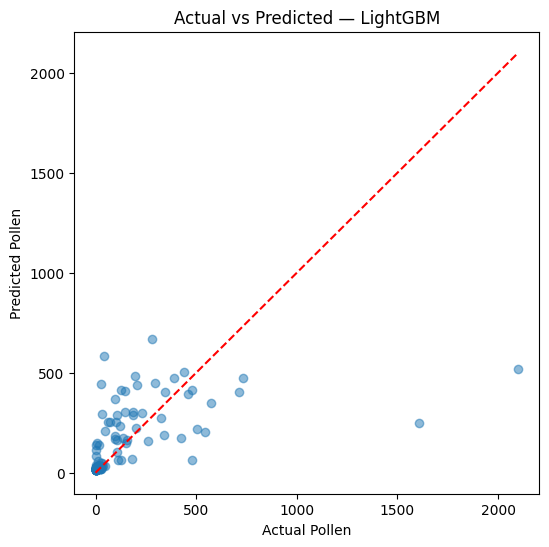

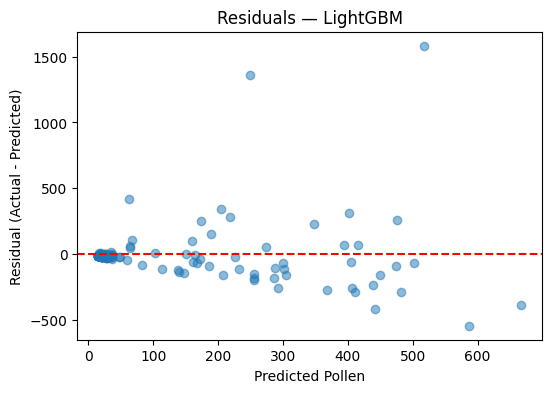

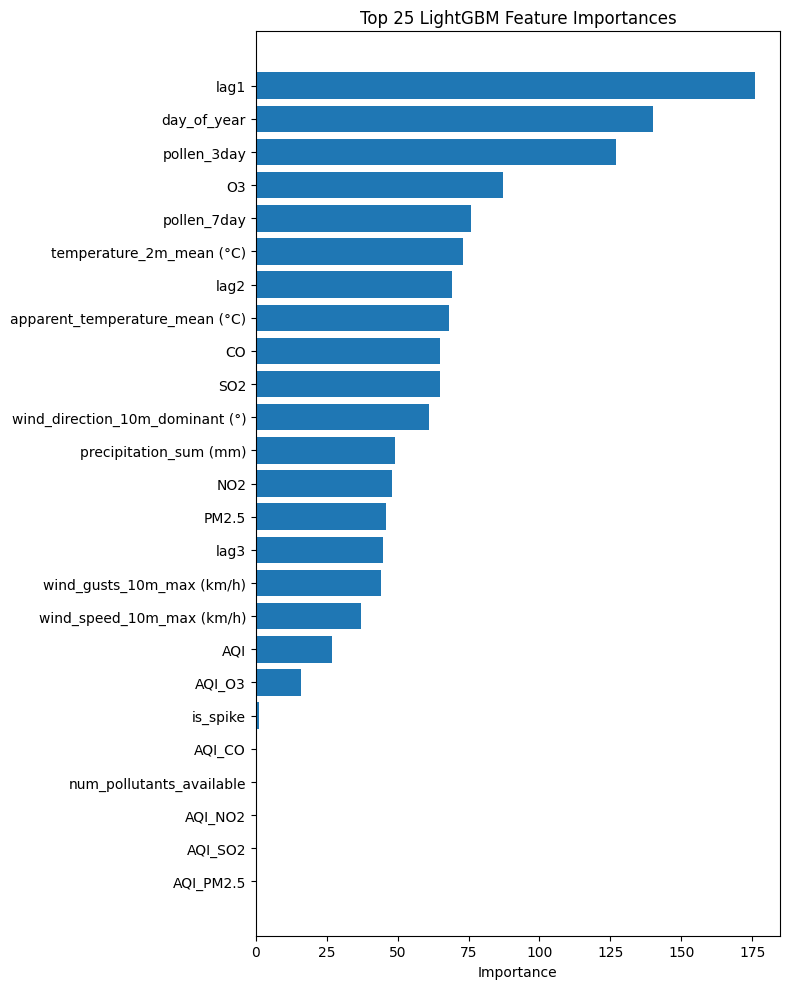

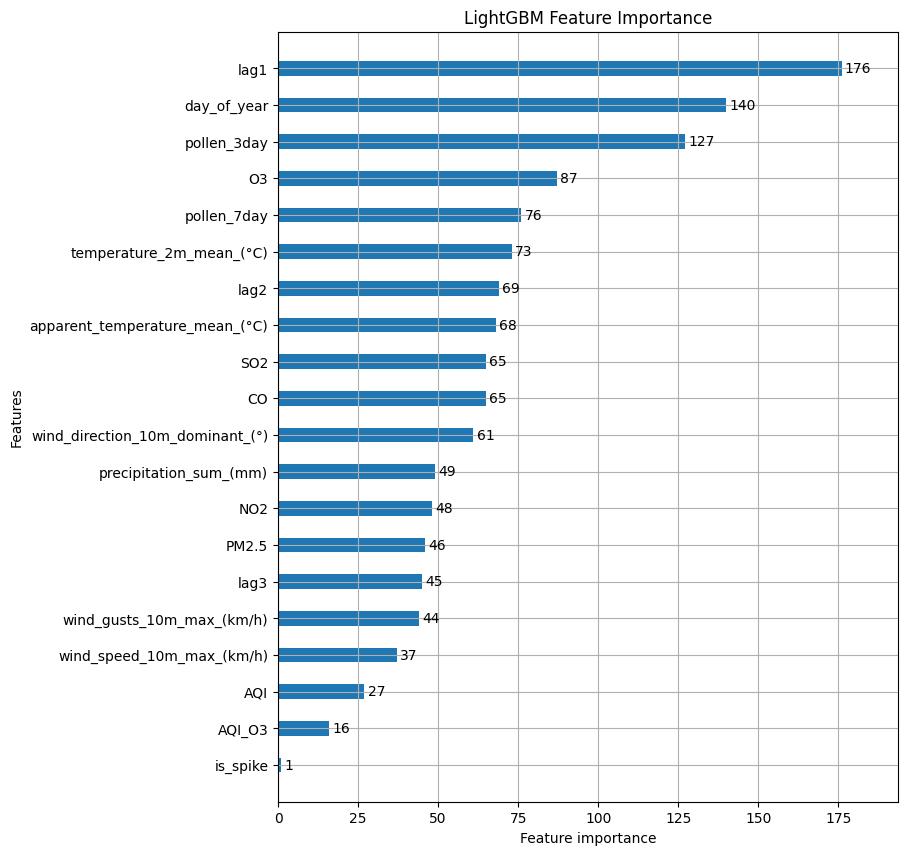

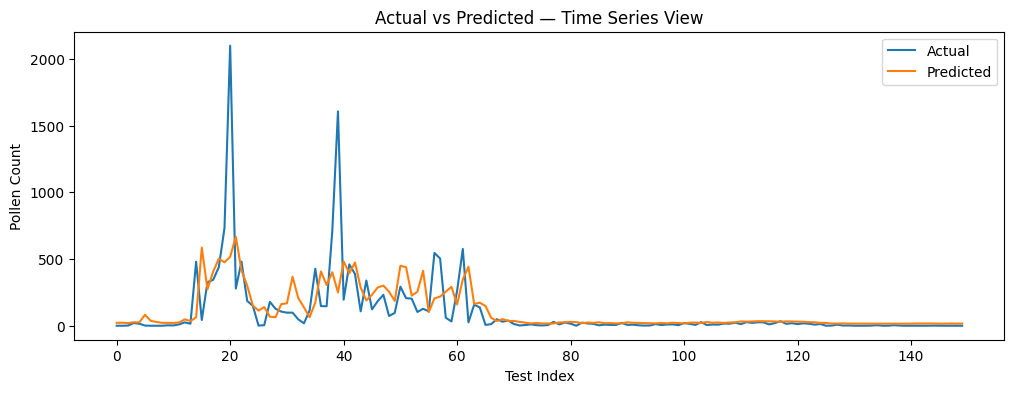

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Ensure numeric columns are truly numeric
for col in numeric.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing numeric values
df[numeric.columns] = df[numeric.columns].fillna(0)

# Create lag and rolling features
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].shift(1).rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].shift(1).rolling(7).mean()

# Spike feature
df["is_spike"] = ((df["Total_Pollen"].shift(1) - df["pollen_3day"]) > df["pollen_3day"].quantile(0.75)).astype(int)

# Drop rows with NaNs in rolling/lag features
df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# --------------------------
# 2. Define target & features
# --------------------------
target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]
features = base_features + extra_features

X = df[features].copy()
y = df[target]

# --------------------------
# 3. Train/test split by year (2024 test)
# --------------------------
df['Year'] = df['Date'].dt.year

train_df = df[df['Year'] < 2023]
test_df = df[df['Year'] == 2023]

X_train = X.loc[train_df.index]
y_train = y.loc[train_df.index]

X_test = X.loc[test_df.index]
y_test = y.loc[test_df.index]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --------------------------
# 4. LightGBM model
# --------------------------
lgb_reg = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

lgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# --------------------------
# 5. Predictions
# --------------------------
y_pred = lgb_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 6. Feature importance
# --------------------------
importances = pd.DataFrame({
    "feature": features,
    "importance": lgb_reg.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Pollen")
plt.ylabel("Predicted Pollen")
plt.title("Actual vs Predicted — LightGBM")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals — LightGBM")
plt.show()

top_k = 25
top_feats = importances.head(top_k).sort_values("importance")
plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k} LightGBM Feature Importances")
plt.tight_layout()
plt.show()

lgb.plot_importance(lgb_reg, max_num_features=25, height=0.4, figsize=(8, 10))
plt.title("LightGBM Feature Importance")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted — Time Series View")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()


# LightGBM with log transforming pollen

--- Training Initial Model for Feature Selection ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6640
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 36
[LightGBM] [Info] Start training from score 3.227489
Training until validation scores don't improve for 50 rounds


[50]	valid_0's rmse: 1.01963	valid_0's l2: 1.03965


[100]	valid_0's rmse: 1.00691	valid_0's l2: 1.01387


Early stopping, best iteration is:
[84]	valid_0's rmse: 0.999156	valid_0's l2: 0.998313

--- Selected Features ---
['day_sin', 'precipitation_sum_mm', 'wind_direction_10m_dominant_°', 'pollen_2day', 'O3', 'day_cos', 'temperature_2m_mean_°C', 'apparent_temperature_mean_°C', 'pollen_ratio_1d_7d', 'lag_30', 'wind_speed_10m_max_km/h', 'CO', 'NO2', 'lag_21', 'lag_1', 'pollen_3day', 'lag_2', 'pollen_7day', 'lag_7', 'pollen_30day', 'lag_14', 'SO2', 'PM2.5', 'AQI', 'wind_gusts_10m_max_km/h', 'lag_4']

--- Retraining Final Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5939
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 26
[LightGBM] [Info] Start training from score 3.227489
Training until validation scores don't improve for 50 rounds


[50]	valid_0's rmse: 1.01681	valid_0's l2: 1.03389


[100]	valid_0's rmse: 0.993355	valid_0's l2: 0.986754


[150]	valid_0's rmse: 1.00007	valid_0's l2: 1.00014
Early stopping, best iteration is:
[110]	valid_0's rmse: 0.989304	valid_0's l2: 0.978723

--- Model Evaluation (Test Set: 2023) ---
MAE: 83.97028268806174
RMSE: 224.1058502313282
R²: 0.43175619125163345

--- Feature Importances ---
                          feature  importance
0                         day_sin         232
2   wind_direction_10m_dominant_°         197
1            precipitation_sum_mm         183
4                              O3         167
3                     pollen_2day         157
12                            NO2         148
8              pollen_ratio_1d_7d         146
11                             CO         138
5                         day_cos         130
13                         lag_21         124
14                          lag_1         123
6          temperature_2m_mean_°C         121
17                    pollen_7day         120
7    apparent_temperature_mean_°C         120
19                   polle

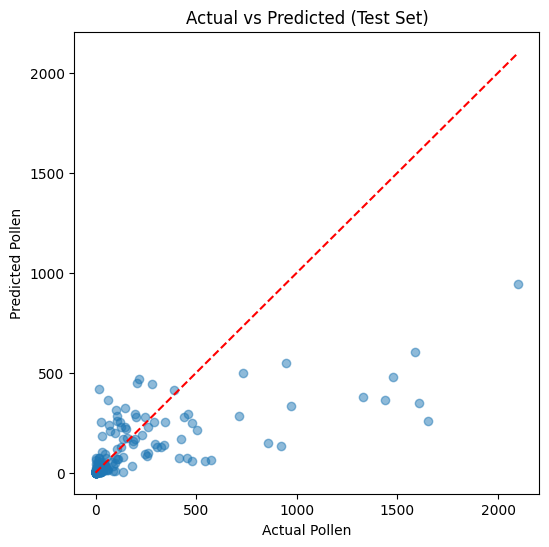

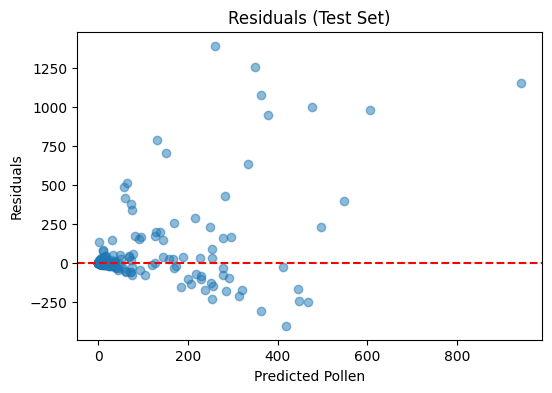

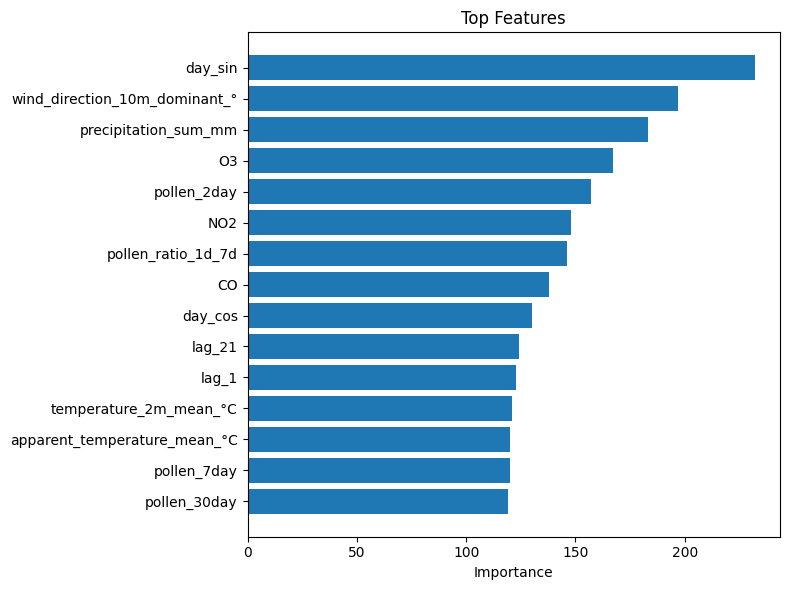

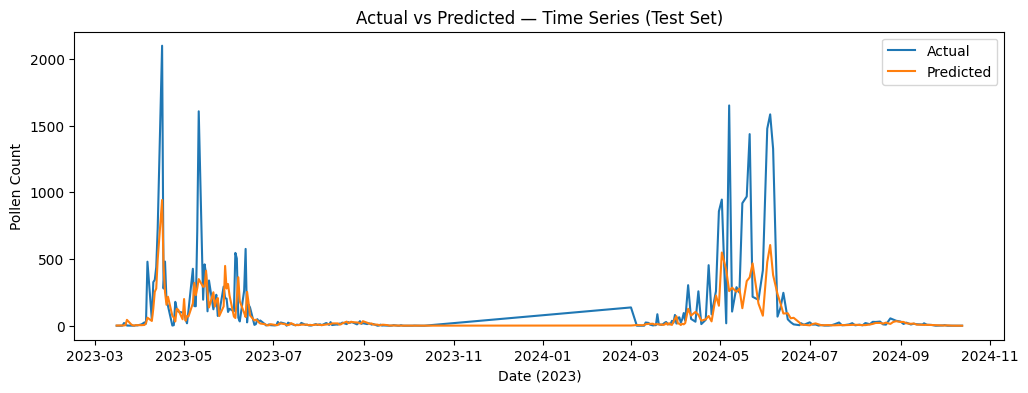

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
## 0. Prepare Dataframe (Setup/Assumptions)
# --------------------------
try:
    merged
except NameError:
    print("WARNING: 'merged' dataframe not found. Creating dummy data.")
    dates = pd.to_datetime(pd.date_range(start='2020-01-01', end='2023-12-31', freq='D'))
    data = {
        "Date": dates,
        "Total_Pollen": np.exp(np.random.normal(3, 1, len(dates))) * (1 + (dates.month % 12)),
        "temperature_2m_mean": np.random.normal(15, 5, len(dates)),
        "Tree": np.random.rand(len(dates)),
        "Grass": np.random.rand(len(dates)),
        "Weed": np.random.rand(len(dates)),
        "Ragweed": np.random.rand(len(dates)),
        "Numeric_Column_1": np.random.rand(len(dates))
    }
    merged = pd.DataFrame(data)
    numeric = [c for c in merged.columns if c != "Date"]

df = merged.copy()

# --------------------------
## 1. Clean Column Names & Numeric Conversion
# --------------------------
df.columns = [c.replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns]
numeric_cols = [c.replace(" ", "_").replace("(", "").replace(")", "") for c in numeric if c.replace(" ", "_").replace("(", "").replace(")", "") in df.columns]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(0)

# --------------------------
## 2. Feature Engineering
# --------------------------
df["day_of_year"] = df["Date"].dt.dayofyear
df["month"] = df["Date"].dt.month

# Cyclical encoding
df["day_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Rolling features (shift(1) ensures no look-ahead/leakage)
df["pollen_2day"] = df["Total_Pollen"].shift(1).rolling(2).mean()
df["pollen_3day"] = df["Total_Pollen"].shift(1).rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].shift(1).rolling(7).mean()
df["pollen_14day"] = df["Total_Pollen"].shift(1).rolling(14).mean()
df["pollen_30day"] = df["Total_Pollen"].shift(1).rolling(30).mean()

# Lagged features
for lag in [1,2,3,4,7,14,21,30]:
    df[f"lag_{lag}"] = df["Total_Pollen"].shift(lag)

# Spike ratio feature
df["pollen_ratio_1d_7d"] = df["lag_1"] / df["pollen_7day"]

# Drop rows with NaNs from rolling
required_cols = ["pollen_30day"] # Only need the max window for cleaning
df = df.dropna(subset=required_cols).copy()

# --------------------------
## 3. Train/Validation/Test Split by Year 🎯 (Leakage Fix)
# --------------------------
df["Year"] = df["Date"].dt.year
# Train: 2020-2021
# Validation: 2022 (Used for early stopping/feature selection)
# Test: 2023 (Final, unseen evaluation)
train_df = df[df["Year"] < 2022].copy()
val_df = df[df["Year"] == 2022].copy()
test_df = df[df['Year'] >= 2023]

# --------------------------
## 4. Target and Spike Feature Transformation
# --------------------------
# Calculate transformations only on the training set
train_cap = train_df["Total_Pollen"].quantile(0.99)
spike_threshold = train_df["pollen_ratio_1d_7d"].quantile(0.95)

def apply_transformations(data_df, cap_val, spike_thresh):
    """Applies capping, log transform, and spike feature based on training stats."""
    data_df["Total_Pollen_capped"] = data_df["Total_Pollen"].clip(upper=cap_val)
    data_df["log_total_pollen"] = np.log1p(data_df["Total_Pollen_capped"])
    data_df["is_spike"] = (data_df["pollen_ratio_1d_7d"] > spike_thresh).astype(int)
    return data_df

train_df = apply_transformations(train_df, train_cap, spike_threshold)
val_df = apply_transformations(val_df, train_cap, spike_threshold)
test_df = apply_transformations(test_df, train_cap, spike_threshold)

# --------------------------
## 5. Define Features
# --------------------------
target = "log_total_pollen"
remove_cols = ["Tree","Grass","Weed","Ragweed","Total_Pollen","Total_Pollen_capped","log_total_pollen","Date","Year","day_of_year","month"]

base_features = [c for c in numeric_cols if c not in remove_cols]
extra_features = [
    "day_sin","day_cos","month_sin","month_cos",
    "pollen_2day","pollen_3day","pollen_7day","pollen_14day","pollen_30day",
    "lag_1","lag_2","lag_3","lag_4","lag_7","lag_14","lag_21","lag_30",
    "pollen_ratio_1d_7d","is_spike"
]
features = base_features + extra_features

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]
X_test = test_df[features]
y_test = test_df[target]
y_test_original = test_df["Total_Pollen"]

# Sample weights for spikes
train_weights = np.where(train_df["is_spike"]==1, 10, 1)

# --------------------------
## 6. LightGBM Model & Feature Selection (Leakage Fix)
# --------------------------
print("--- Training Initial Model for Feature Selection ---")

# Use Validation set (X_val, y_val) for Early Stopping
lgb_reg = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
lgb_reg.fit(
    X_train, y_train,
    sample_weight=train_weights,
    eval_set=[(X_val, y_val)], # <-- Leakage Fix: Use validation set here
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# Feature importances
importances = pd.DataFrame({"feature": features, "importance": lgb_reg.feature_importances_}).sort_values(by="importance", ascending=False)
selected_features = importances[importances["importance"]>50]["feature"].tolist()
print("\n--- Selected Features ---")
print(selected_features)

X_train_trim = X_train[selected_features]
X_val_trim = X_val[selected_features]
X_test_trim = X_test[selected_features]
train_weights_trim = train_weights[:X_train_trim.shape[0]]

print("\n--- Retraining Final Model ---")
# Retrain using trimmed features
lgb_reg_trim = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1)
lgb_reg_trim.fit(
    X_train_trim, y_train,
    sample_weight=train_weights_trim,
    eval_set=[(X_val_trim, y_val)], # <-- Use validation set again
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# --------------------------
## 7. Predictions & Evaluation on Test Set (2023)
# --------------------------
y_pred_log = lgb_reg_trim.predict(X_test_trim)
y_pred = np.expm1(y_pred_log)

print("\n--- Model Evaluation (Test Set: 2023) ---")
print("MAE:", mean_absolute_error(y_test_original, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_original, y_pred)))
print("R²:", r2_score(y_test_original, y_pred))

# Feature importances
importances_trim = pd.DataFrame({"feature": selected_features, "importance": lgb_reg_trim.feature_importances_}).sort_values(by="importance", ascending=False)
print("\n--- Feature Importances ---")
print(importances_trim)

# --------------------------
## 8. Visualizations
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel("Actual Pollen")
plt.ylabel("Predicted Pollen")
plt.title("Actual vs Predicted (Test Set)")
plt.show()

residuals = y_test_original - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals")
plt.title("Residuals (Test Set)")
plt.show()

top_feats = importances_trim.head(15).sort_values("importance")
plt.figure(figsize=(8,6))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title("Top Features")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(test_df["Date"].values, y_test_original.values, label="Actual")
plt.plot(test_df["Date"].values, y_pred, label="Predicted")
plt.xlabel("Date (2023)")
plt.ylabel("Pollen Count")
plt.title("Actual vs Predicted — Time Series (Test Set)")
plt.legend()
plt.show()

# Classification model

--- Training Three Independent Models (Tree, Weed, Grass) ---

Training Model for: **Tree_Level**
  Class Counts: {0: 912, 1: 260, 2: 241, 3: 316, 4: 14}
  Class Weights: {0 (None), 1 (Low), 2 (Mod), 3 (High), 4 (V.High)} = {0: np.float64(0.38223684210526315), 1: np.float64(1.3407692307692307), 2: np.float64(1.4464730290456431), 3: np.float64(1.1031645569620254), 4: np.float64(24.9)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8756
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 57
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive ga

[50]	valid_0's multi_logloss: 0.55019


[100]	valid_0's multi_logloss: 0.594182


Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.53622

Training Model for: **Grass_Level**
  Class Counts: {0: 1108, 1: 314, 2: 186, 3: 133, 4: 2}
  Class Weights: {0 (None), 1 (Low), 2 (Mod), 3 (High), 4 (V.High)} = {0: np.float64(0.3146209386281588), 1: np.float64(1.1101910828025479), 2: np.float64(1.8741935483870968), 3: np.float64(2.6210526315789475), 4: np.float64(174.3)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8756
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 57
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with

[50]	valid_0's multi_logloss: 0.729726


[100]	valid_0's multi_logloss: 0.78833


Early stopping, best iteration is:
[53]	valid_0's multi_logloss: 0.725112

Training Model for: **Weed_Level**
  Class Counts: {0: 828, 1: 550, 2: 297, 3: 68}
  Class Weights: {0 (None), 1 (Low), 2 (Mod), 3 (High), 4 (V.High)} = {0: np.float64(0.5262681159420289), 1: np.float64(0.7922727272727272), 2: np.float64(1.4671717171717171), 3: np.float64(6.408088235294118)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8756
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 57
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50

[50]	valid_0's multi_logloss: 0.536608


[100]	valid_0's multi_logloss: 0.551975


Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.529351

--- Model Evaluation (Test Set: 2023) for **Tree_Level** ---
Accuracy: 0.75

Classification Report:
                precision    recall  f1-score   support

     None (0)       0.97      0.91      0.94       123
      Low (1)       0.59      0.64      0.61        42
 Moderate (2)       0.40      0.41      0.41        34
     High (3)       0.71      0.72      0.72        58
Very High (4)       0.00      0.00      0.00         3

     accuracy                           0.75       260
    macro avg       0.53      0.54      0.53       260
 weighted avg       0.76      0.75      0.76       260


Confusion Matrix:
 [[112  10   1   0   0]
 [  4  27   7   4   0]
 [  0   8  14  10   2]
 [  0   1  13  42   2]
 [  0   0   0   3   0]]

--- Model Evaluation (Test Set: 2023) for **Grass_Level** ---
Accuracy: 0.7538461538461538

Classification Report:
                precision    recall  f1-score   support

     None (0)    

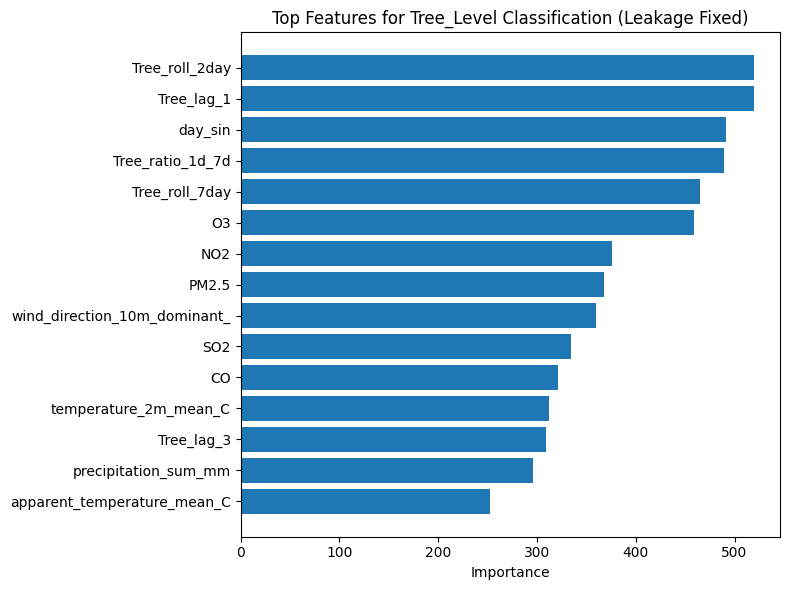

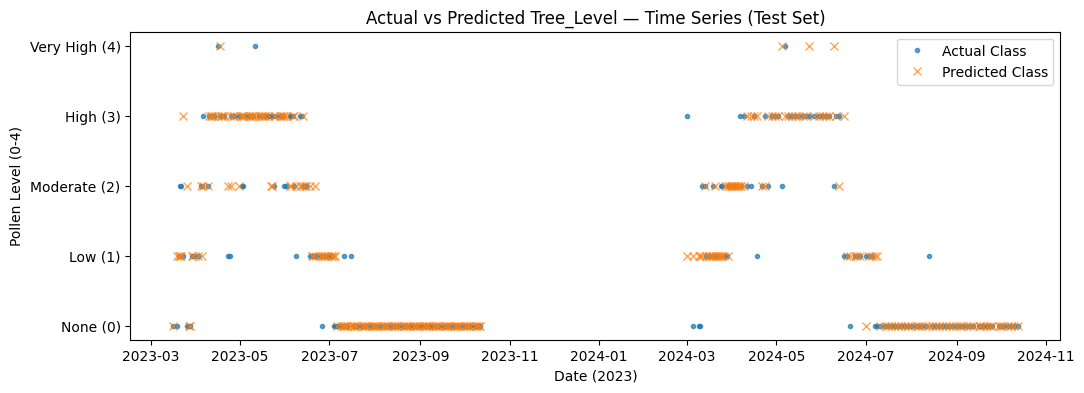

In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# --------------------------
## 0. Prepare Dataframe (Setup/Assumptions)
# --------------------------
try:
    merged
except NameError:
    print("WARNING: 'merged' dataframe not found. Creating dummy data.")
    dates = pd.to_datetime(pd.date_range(start='2020-01-01', end='2023-12-31', freq='D'))
    
    # Create dummy data
    len_dates = len(dates)
    data = {
        "Date": dates,
        # Total_Pollen is now irrelevant for feature engineering and prediction, but keep it if needed for context
        "Total_Pollen": np.exp(np.random.normal(5, 1.5, len_dates)) * (1 + (dates.month % 12)),
        "temperature_2m_mean_°C": np.random.normal(15, 5, len_dates),
        "Tree": np.exp(np.random.normal(4, 2, len_dates)) * (1 + (dates.month % 12)),
        "Grass": np.exp(np.random.normal(2, 1, len_dates)) * (1 + (dates.month % 12)),
        "Weed": np.exp(np.random.normal(3, 1.5, len_dates)) * (1 + (dates.month % 12)),
        "Ragweed": np.random.rand(len_dates) * 50,
        "Numeric_Column_1": np.random.rand(len_dates) * 10,
        "wind_direction_10m_dominant_°": np.random.randint(0, 360, len_dates),
        "apparent_temperature_mean_°C": np.random.normal(15, 6, len_dates),
        "precipitation_sum_mm": np.random.rand(len_dates) * 10,
        "O3": np.random.rand(len_dates) * 50, "SO2": np.random.rand(len_dates) * 10, 
        "NO2": np.random.rand(len_dates) * 20, "PM2.5": np.random.rand(len_dates) * 30,
        "CO": np.random.rand(len_dates) * 5, "AQI": np.random.randint(0, 100, len_dates)
    }
    merged = pd.DataFrame(data)
    numeric = [c for c in merged.columns if c != "Date"]

df = merged.copy()

# --------------------------
## 1. Clean Column Names & Numeric Conversion
# --------------------------
df.columns = [c.replace(" ", "_").replace("(", "").replace(")", "").replace("°", "") for c in df.columns]
numeric_cols = [c.replace(" ", "_").replace("(", "").replace(")", "").replace("°", "") for c in numeric if c.replace(" ", "_").replace("(", "").replace(")", "").replace("°", "") in df.columns]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(0)

# --------------------------
## 2. Feature Engineering (FIXED: Using lagged individual pollen counts instead of Total_Pollen)
# --------------------------
df["day_of_year"] = df["Date"].dt.dayofyear
df["month"] = df["Date"].dt.month

# Cyclical encoding
df["day_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# --- Feature Engineering Fix: Create separate lagged/rolling features for each pollen type ---
Pollen_Types = ["Tree", "Grass", "Weed"]
Lag_Days = [1, 2, 3, 4, 7, 14, 21, 30]

engineered_pollen_features = []

for pollen_type in Pollen_Types:
    # Rolling features (shift(1) ensures no look-ahead/leakage)
    df[f"{pollen_type}_roll_2day"] = df[pollen_type].shift(1).rolling(2).mean()
    df[f"{pollen_type}_roll_7day"] = df[pollen_type].shift(1).rolling(7).mean()
    df[f"{pollen_type}_roll_30day"] = df[pollen_type].shift(1).rolling(30).mean()
    engineered_pollen_features.extend([
        f"{pollen_type}_roll_2day", f"{pollen_type}_roll_7day", f"{pollen_type}_roll_30day"
    ])

    # Lagged features
    for lag in Lag_Days:
        df[f"{pollen_type}_lag_{lag}"] = df[pollen_type].shift(lag)
        engineered_pollen_features.append(f"{pollen_type}_lag_{lag}")

    # Spike ratio feature
    df[f"{pollen_type}_ratio_1d_7d"] = df[f"{pollen_type}_lag_1"] / df[f"{pollen_type}_roll_7day"]
    engineered_pollen_features.append(f"{pollen_type}_ratio_1d_7d")
# ---------------------------------------------------------------------------------------------

# Drop rows with NaNs from rolling (now based on individual pollen types)
required_cols = [f"{pt}_roll_30day" for pt in Pollen_Types]
df = df.dropna(subset=required_cols).copy()

# --------------------------
## 3. Train/Validation/Test Split by Year 🎯
# --------------------------
df["Year"] = df["Date"].dt.year
train_df = df[df["Year"] < 2022].copy()
val_df = df[df["Year"] == 2022].copy()
test_df = df[df['Year'] >= 2023]

# --------------------------
## 4. Target Transformation: CONVERT TO MULTIPLE CATEGORICAL LABELS 
# --------------------------

def classify_tree_pollen(count):
    """0:None, 1:Low (1-14), 2:Moderate (15-89), 3:High (90-1499), 4:Very High (>=1500)"""
    if count < 1: return 0
    elif count <= 14: return 1
    elif count <= 89: return 2
    elif count <= 1499: return 3
    else: return 4

def classify_weed_pollen(count):
    """0:None, 1:Low (1-9), 2:Moderate (10-49), 3:High (50-499), 4:Very High (>=500)"""
    if count < 1: return 0
    elif count <= 9: return 1
    elif count <= 49: return 2
    elif count <= 499: return 3
    else: return 4

def classify_grass_pollen(count):
    """0:None, 1:Low (1-4), 2:Moderate (5-19), 3:High (20-199), 4:Very High (>=200)"""
    if count < 1: return 0
    elif count <= 4: return 1
    elif count <= 19: return 2
    elif count <= 199: return 3
    else: return 4

def apply_transformations(data_df):
    """Applies classification to the Tree, Weed, and Grass columns."""
    data_df["Tree_Level"] = data_df["Tree"].apply(classify_tree_pollen).astype('category')
    data_df["Weed_Level"] = data_df["Weed"].apply(classify_weed_pollen).astype('category')
    data_df["Grass_Level"] = data_df["Grass"].apply(classify_grass_pollen).astype('category')
    return data_df

train_df = apply_transformations(train_df)
val_df = apply_transformations(val_df)
test_df = apply_transformations(test_df)


# --------------------------
## 5. Define Features (FIXED: Updated features list)
# --------------------------
Target_Levels = [f"{pt}_Level" for pt in Pollen_Types]

# Features: exclude the original continuous pollen counts and old target columns
remove_cols = ["Tree","Grass","Weed","Ragweed","Total_Pollen","Date","Year","day_of_year","month"]
remove_cols.extend(Target_Levels)

# Remove the 'pollen' column names from the numeric columns before defining base features
numeric_no_pollen_cols = [c for c in numeric_cols if c not in ["Tree","Grass","Weed","Ragweed","Total_Pollen"]]

base_features = [c for c in numeric_no_pollen_cols if c not in remove_cols]
extra_features = [
    "day_sin","day_cos","month_sin","month_cos",
]

# Add the newly engineered, type-specific lagged/rolling features
extra_features.extend(engineered_pollen_features) 

features = base_features + extra_features

X_train_full = train_df[features]
X_val_full = val_df[features]
X_test_full = test_df[features]

# --------------------------
## 6. Train Three Separate Classification Models 
# --------------------------
Trained_Models = {}
Test_Predictions = {}

print("--- Training Three Independent Models (Tree, Weed, Grass) ---")

for target in Target_Levels:
    print(f"\nTraining Model for: **{target}**")

    y_train_target = train_df[target]
    y_val_target = val_df[target]

    # Calculate class weights based on the current target's training data
    class_counts = y_train_target.value_counts().sort_index()
    total_samples = len(y_train_target)
    num_classes = len(class_counts)
    
    # Ensure all classes from 0 to max_level are accounted for (for robust classification)
    max_level = max(class_counts.index)
    
    class_weights = {}
    for i in range(max_level + 1):
        count = class_counts.get(i, 1e-6) # Use a tiny number if class is missing to avoid division by zero
        class_weights[i] = total_samples / (num_classes * count)
    
    print(f"  Class Counts: {class_counts.to_dict()}")
    print(f"  Class Weights: {{0 (None), 1 (Low), 2 (Mod), 3 (High), 4 (V.High)}} = {class_weights}")
    
    # Initialize the classifier
    lgb_clf = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=max_level + 1, # e.g., 5 classes (0 to 4)
        n_estimators=1000,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weights # Apply weights for imbalance
    )
    
    # Train the model
    lgb_clf.fit(
        X_train_full, y_train_target,
        eval_set=[(X_val_full, y_val_target)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )
    
    # Store the trained model
    Trained_Models[target] = lgb_clf
    
    # Generate predictions on the test set
    y_pred = lgb_clf.predict(X_test_full)
    Test_Predictions[target] = y_pred


# --------------------------
## 7. Predictions & Evaluation on Test Set (2023) 
# --------------------------
target_names_4 = ['None (0)', 'Low (1)', 'Moderate (2)', 'High (3)', 'Very High (4)']
full_labels = [0, 1, 2, 3, 4] 

for target in Target_Levels:
    print(f"\n--- Model Evaluation (Test Set: 2023) for **{target}** ---")
    
    y_test_target = test_df[target]
    y_pred_class = Test_Predictions[target]
    
    print("Accuracy:", accuracy_score(y_test_target, y_pred_class))
    
    # Classification Report 
    print("\nClassification Report:\n", classification_report(
        y_test_target, 
        y_pred_class, 
        target_names=target_names_4, 
        labels=full_labels, 
        zero_division=0
    ))
    
    # Confusion Matrix 
    conf_matrix = confusion_matrix(y_test_target, y_pred_class, labels=full_labels)
    print("\nConfusion Matrix:\n", conf_matrix)

# --------------------------
## 8. Visualizations 
# --------------------------

# Display feature importances for one model (e.g., Tree_Level)
target_to_plot = "Tree_Level"
lgb_clf_plot = Trained_Models[target_to_plot]

importances_trim = pd.DataFrame({"feature": features, "importance": lgb_clf_plot.feature_importances_}).sort_values(by="importance", ascending=False)
print(f"\n--- Feature Importances for {target_to_plot} Model ---")
print(importances_trim.head(15))

top_feats = importances_trim.head(15).sort_values("importance")
plt.figure(figsize=(8,6))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title(f"Top Features for {target_to_plot} Classification (Leakage Fixed)")
plt.tight_layout()
plt.show()

# Time series plot for one classification result (e.g., Tree_Level)
y_test_plot = test_df[target_to_plot].values
y_pred_plot = Test_Predictions[target_to_plot]

plt.figure(figsize=(12,4))
plt.plot(test_df["Date"].values, y_test_plot, label="Actual Class", marker='.', linestyle='', alpha=0.7)
plt.plot(test_df["Date"].values, y_pred_plot, label="Predicted Class", marker='x', linestyle='', alpha=0.7)
plt.xlabel("Date (2023)")
plt.ylabel("Pollen Level (0-4)")
plt.title(f"Actual vs Predicted {target_to_plot} — Time Series (Test Set)")
plt.yticks(range(len(target_names_4)), target_names_4)
plt.legend()
plt.show()

# 5. XGBoost


Train size: (1909, 75)
Test size: (150, 75)


[0]	train-rmse:263.39222	eval-rmse:248.56006


[50]	train-rmse:86.37480	eval-rmse:217.31320


[82]	train-rmse:58.48498	eval-rmse:220.88757



--- Model Performance ---
MAE: 89.70959064006806
RMSE: 220.88757737693896
R²: 0.23491455979557951

--- Feature Importance ---
             feature    importance
10              lag1  1.715310e+06
13       pollen_3day  8.276926e+05
15          is_spike  7.395326e+05
26  AQI_O3_weighted3  4.939346e+05
51          SO2_lag3  4.791750e+05
24     SO2_weighted3  4.257492e+05
55       AQI_O3_lag1  4.064818e+05
59       AQI_CO_lag2  4.030413e+05
47          NO2_lag2  3.957943e+05
22      CO_weighted3  3.924910e+05


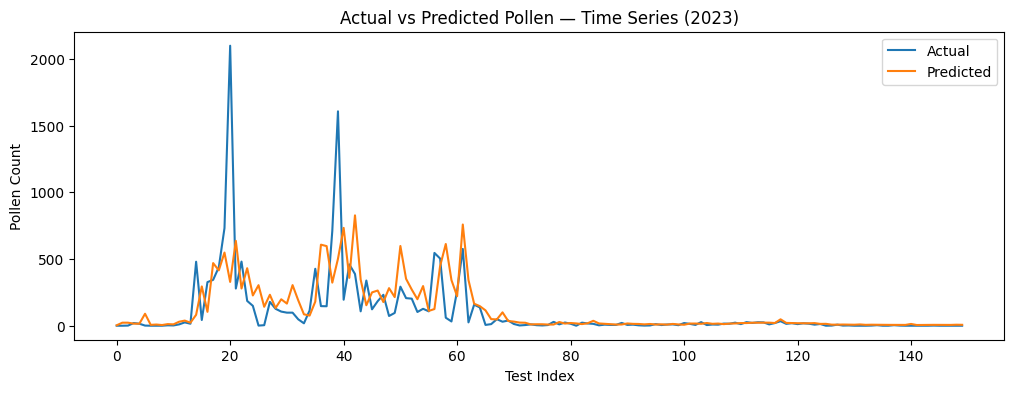

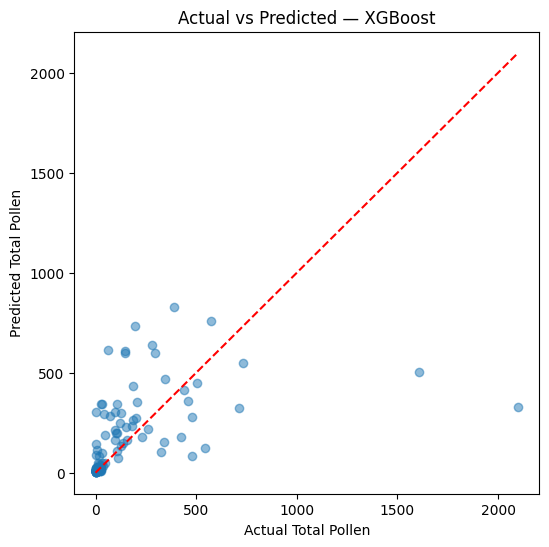

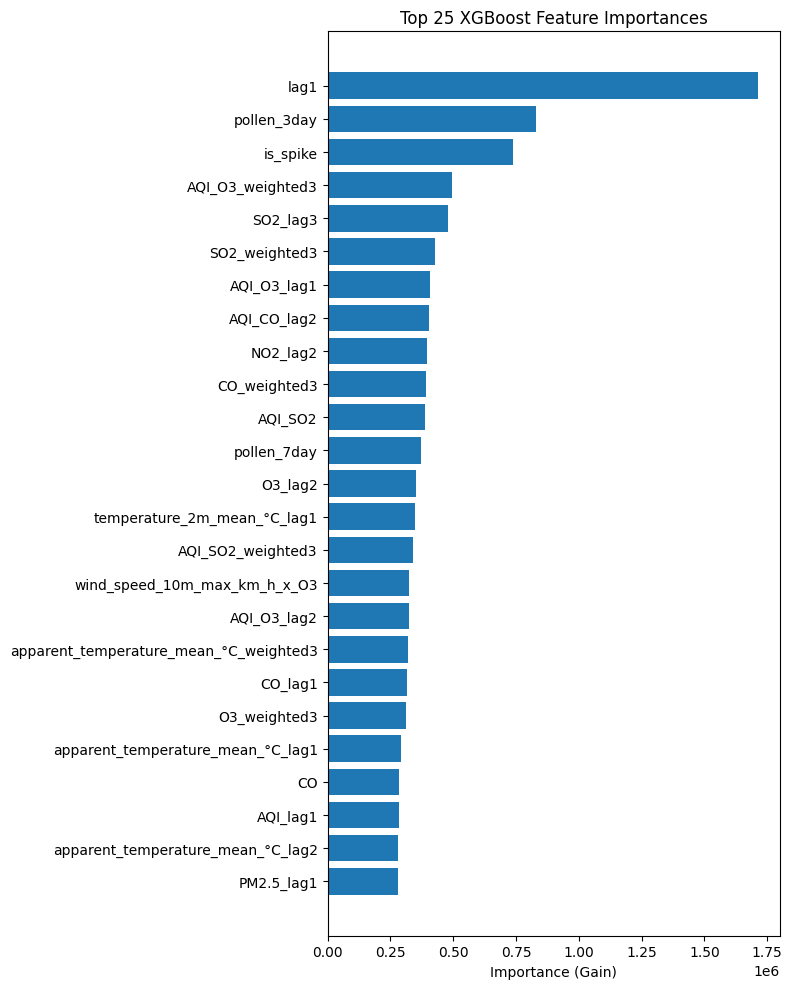

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare dataframe & Time-Series Split (Split FIRST for safe calculation)
# --------------------------
df = merged.copy()

# ----------------------------------
# Normalize dataframe column names
# ----------------------------------
df.columns = (
    df.columns
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("/", "_", regex=False)
)
# Normalize numeric columns list for consistency
numeric_cols = [
    c.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    for c in numeric.columns if c in df.columns
]


# Ensure numeric columns and fill NaNs (Fillna must use ffill or a model trained only on past data)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing numeric values with 0.
df[numeric_cols] = df[numeric_cols].fillna(0)


# --------------------------
# 2. Define Features and Perform Train/Test Split
#    Split is done here to ensure threshold calculations are safe.
# --------------------------
target = "Total_Pollen"

# Split data chronologically (CORRECT METHOD)
df['Year'] = df['Date'].dt.year
train_idx = df[df['Year'] < 2023].index
test_idx = df[df['Year'] == 2023].index

train_df = df.loc[train_idx].copy()
test_df = df.loc[test_idx].copy()
full_df = df.copy() # Keep a copy for calculating lags/rolling across entire series

# --------------------------
# 3. Feature Engineering (Apply to Full Data, but only use safe methods: ffill, shift, rolling)
# --------------------------

# Base lags + rolling (SAFE: Uses .shift(1) and ffill is causal)
full_df["day_of_year"] = full_df["Date"].dt.dayofyear
full_df["lag1"] = full_df[target].shift(1).ffill()
full_df["lag2"] = full_df[target].shift(2).ffill()
full_df["lag3"] = full_df[target].shift(3).ffill()

# Shift(1) before rolling ensures target leakage is avoided
full_df["pollen_3day"] = full_df[target].shift(1).rolling(3).mean().ffill()
full_df["pollen_7day"] = full_df[target].shift(1).rolling(7).mean().ffill()


# Spike indicator (FIXED: Uses only lagged features, avoiding target leakage)
# Using lag1 > rolling mean as a proxy for a sudden spike
full_df["is_spike"] = (full_df["lag1"] > full_df["pollen_3day"]).astype(int)


# Seasonal sin/cos
full_df["sin_day"] = np.sin(2 * np.pi * full_df["day_of_year"] / 365)
full_df["cos_day"] = np.cos(2 * np.pi * full_df["day_of_year"] / 365)

# Weighted rolling (3-day)
weights = np.array([0.1, 0.3, 0.6])
rolling_cols = [
    'temperature_2m_mean_°C', 'apparent_temperature_mean_°C',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

# Weighted rolling (FIXED: Only uses lagged values of weather/pollutants, t-1, t-2, t-3)
for col in rolling_cols:
    if col in full_df.columns:
        full_df[f'{col}_weighted3'] = (
            full_df[col].shift(3).ffill() * weights[0] +
            full_df[col].shift(2).ffill() * weights[1] +
            full_df[col].shift(1).ffill() * weights[2]
        )

# Lag features (FIXED: Uses ffill instead of bfill for causal imputation)
for col in rolling_cols:
    if col in full_df.columns:
        for lag in range(1, 4):
            full_df[f"{col}_lag{lag}"] = full_df[col].shift(lag).ffill()

# Interaction features (SAFE: Uses current day's features which are available on the day of prediction)
interaction_pairs = [
    ('temperature_2m_mean_°C', 'AQI'),
    ('apparent_temperature_mean_°C', 'PM2.5'),
    ('wind_speed_10m_max_km_h', 'O3'),
]

for col1, col2 in interaction_pairs:
    if col1 in full_df.columns and col2 in full_df.columns:
        full_df[f'{col1}_x_{col2}'] = full_df[col1] * full_df[col2]

# Drop rows with NaNs remaining from lag/rolling features (first few days)
full_df = full_df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])


# --------------------------
# 4. Final Data Split & Feature Set Definition
# --------------------------
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen", "Year", "Date"]

base_features = [c for c in numeric_cols if c not in remove_cols]

extra_features = [
    "lag1", "lag2", "lag3",
    "pollen_3day", "pollen_7day",
    "is_spike", "sin_day", "cos_day"
]

weighted_features = [f"{col}_weighted3" for col in rolling_cols if f"{col}_weighted3" in full_df.columns]
lag_features = [f"{col}_lag{lag}" for col in rolling_cols for lag in range(1, 4)]
interaction_features = [f"{a}_x_{b}" for a, b in interaction_pairs]

features = base_features + extra_features + weighted_features + lag_features + interaction_features

# Re-filter features that actually exist in the final df
features = [f for f in features if f in full_df.columns]

# Apply the chronological split indices to the final feature set
X_train = full_df.loc[full_df['Year'] < 2023, features]
y_train = full_df.loc[full_df['Year'] < 2023, target]

X_test = full_df.loc[full_df['Year'] == 2023, features]
y_test = full_df.loc[full_df['Year'] == 2023, target]


print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --------------------------
# 5. Convert to DMatrix
# --------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --------------------------
# 6. XGBoost parameters
# --------------------------
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'seed': 42
}

# --------------------------
# 7. Train with early stopping
# --------------------------
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# --------------------------
# 8. Predictions and Evaluation (Rest of the code remains the same)
# --------------------------
y_pred = xgb_model.predict(dtest)

print("\n--- Model Performance ---")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 9. Feature importance
# --------------------------
importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print("\n--- Feature Importance ---")
print(importance_df.head(10))

# --------------------------
# 10. Visualizations
# --------------------------

# Time series view of predictions vs actual
plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series (2023)")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted — XGBoost")
plt.show()

# Feature importance plot
top_k = 25
top_feats = importance_df.head(top_k).sort_values("importance")
plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance (Gain)")
plt.title(f"Top {top_k} XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# two stage model with same day weather data 

In [8]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# --------------------------
## 0. Prepare Dataframe
# --------------------------
def standardize_columns(df):
    cols = df.columns
    cols = (
        cols.str.strip()
        .str.lower()
        .str.replace('°c','', regex=False)
        .str.replace('°','', regex=False)
        .str.replace('mm','', regex=False)
        .str.replace('/','_', regex=False)
        .str.replace(' ', '_', regex=False)
        .str.replace('(', '', regex=False)
        .str.replace(')', '', regex=False)
        .str.replace('.', '_', regex=False)
    )
    df.columns = cols
    return df

# Dummy dataset if needed
try:
    merged
except NameError:
    dates = pd.to_datetime(pd.date_range(start='2020-01-01', end='2023-12-31', freq='D'))
    data = {
        "Date": dates,
        "Total_Pollen": np.exp(np.random.normal(3, 1, len(dates))) * (1 + (dates.month % 12)),
        "temperature_2m_mean": np.random.normal(15, 5, len(dates)),
        "relativehumidity_2m_mean": np.random.uniform(30, 90, len(dates)),
        "wind_speed_10m_max": np.random.uniform(0, 20, len(dates)),
        "precipitation_sum": np.random.uniform(0, 10, len(dates)),
        "Numeric_Column_1": np.random.rand(len(dates))
    }
    merged = pd.DataFrame(data)

df = standardize_columns(merged)
df['date'] = pd.to_datetime(df['date'])

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# --------------------------
## 1. Feature Engineering (Past pollen + forecasted weather)
# --------------------------
def make_time_features(df):
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

def make_lags_rolls(df, target_col='total_pollen', lags=[1,2,3,4,7,14,21,30], rolls=[2,3,7,14,30]):
    """Lagged/rolling pollen features for next-day prediction."""
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for r in rolls:
        df[f'pollen_{r}day'] = df[target_col].shift(1).rolling(window=r, min_periods=1).mean()
    df['pollen_ratio_1d_7d'] = df['lag_1'] / (df['pollen_7day'] + 1e-8)
    return df

def make_weather_forecast_features(df, weather_cols):
    """Shift weather by 1 to simulate forecast (predicting next day)."""
    for col in weather_cols:
        if col in df.columns:
            df[f'{col}_forecast'] = df[col].shift(1)
    return df

df = make_time_features(df)
df = make_lags_rolls(df)
weather_cols = ['temperature_2m_mean', 'relativehumidity_2m_mean', 'wind_speed_10m_max', 'precipitation_sum']
df = make_weather_forecast_features(df, weather_cols)

# Fill missing values
df[numeric_cols] = df[numeric_cols].fillna(method='ffill').fillna(0)
df = df.dropna(subset=['pollen_30day']).copy()

# --------------------------
## 2. Train/Val/Test Split
# --------------------------
df['year'] = df['date'].dt.year
train_df = df[df['year'] < 2022].copy()
val_df   = df[df['year'] == 2022].copy()
test_df  = df[df['year'] >= 2023].copy()

# --------------------------
## 3. Spike Labeling & Target Transform
# --------------------------
def asinh_transform(x): return np.arcsinh(x)
def asinh_inverse(x): return np.sinh(x)

base_mean = train_df['pollen_ratio_1d_7d'].mean()
base_std = train_df['pollen_ratio_1d_7d'].std(ddof=0)
z_thresh = 1.64

for df_ in [train_df, val_df, test_df]:
    df_['spike_z'] = (df_['pollen_ratio_1d_7d'] - base_mean) / (base_std + 1e-8)
    df_['is_spike'] = (df_['spike_z'] > z_thresh).astype(int)
    df_['target_asinh'] = asinh_transform(df_['total_pollen'])

# --------------------------
## 4. Features
# --------------------------
exclude_cols = {'date','year','total_pollen','weed','tree','grass','target_asinh','is_spike','spike_z'}
all_features = [c for c in train_df.columns if c not in exclude_cols and train_df[c].dtype in [np.float64, np.int64]]

all_features = [c for c in all_features if train_df[c].nunique() > 1]

X_train = train_df[all_features]; y_train = train_df['target_asinh']
X_val = val_df[all_features]; y_val = val_df['target_asinh']
X_test = test_df[all_features]; y_test_original = test_df['total_pollen']

# --------------------------
## 5. Train Classifier
# --------------------------
clf_params = {"n_estimators":1000,"learning_rate":0.05,"num_leaves":31,"min_data_in_leaf":20,
              "feature_fraction":0.8,"bagging_fraction":0.8,"bagging_freq":5,"random_state":42,"n_jobs":-1}
clf = lgb.LGBMClassifier(**clf_params)
clf.fit(X_train, train_df['is_spike'])
val_spike_prob = clf.predict_proba(X_val)[:,1]
test_spike_prob = clf.predict_proba(X_test)[:,1]
print(f"Classifier val AUC: {roc_auc_score(val_df['is_spike'], val_spike_prob):.3f}")

# --------------------------
## 6. Train Regressors
# --------------------------
reg_params = {"n_estimators":3000,"learning_rate":0.03,"num_leaves":64,"min_data_in_leaf":40,
              "lambda_l1":1.0,"lambda_l2":1.0,"feature_fraction":0.8,"bagging_fraction":0.8,
              "bagging_freq":5,"random_state":42,"n_jobs":-1}

reg_normal = lgb.LGBMRegressor(**reg_params)
reg_normal.fit(X_train[train_df['is_spike']==0], y_train[train_df['is_spike']==0])

reg_spike = lgb.LGBMRegressor(**reg_params)
reg_spike.fit(X_train[train_df['is_spike']==1], y_train[train_df['is_spike']==1])

# --------------------------
## 7. Feature Importance
# --------------------------
def print_feature_importance(model, model_name):
    importance = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"\nFeature Importance for {model_name}:\n", importance)
    return importance

clf_importance = print_feature_importance(clf, "Spike Classifier")
reg_normal_importance = print_feature_importance(reg_normal, "Normal Regressor")
reg_spike_importance = print_feature_importance(reg_spike, "Spike Regressor")

# --------------------------
## 8. Predictions
# --------------------------
pred_normal_test = reg_normal.predict(X_test)
pred_spike_test = reg_spike.predict(X_test)
combined_test_trans = test_spike_prob * pred_spike_test + (1 - test_spike_prob) * pred_normal_test
y_pred_test = asinh_inverse(combined_test_trans)

mae = mean_absolute_error(y_test_original, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test))
r2 = r2_score(y_test_original, y_pred_test)
print(f"\nTest MAE: {mae:.3f}, RMSE: {rmse:.3f}, R^2: {r2:.3f}")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 119, number of negat

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Classifier val AUC: 1.000
[LightGBM] [Warning] min_data_in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Cu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


Feature Importance for Spike Classifier:
                          feature  importance
39            pollen_ratio_1d_7d        1120
26                         lag_1         691
22                       day_sin         298
29                         lag_4         254
9                            no2         251
38                  pollen_30day         207
37                  pollen_14day         196
30                         lag_7         187
19                          week         183
4        wind_speed_10m_max_km_h         168
18                           day         161
36                   pollen_7day         150
3        wind_gusts_10m_max_km_h         136
32                        lag_21         130
34                   pollen_2day         124
2     apparent_temperature_mean_         121
31                        lag_14         112
35                   pollen_3day         111
23                       day_cos         104
28                         lag_3         100
10          

# above with no same-day weather data 


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 119, number of negat

Early stopping, best iteration is:
[12]	valid_0's auc: 0.982587	valid_0's binary_logloss: 0.133217
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[140]	valid_0's l2: 1.12652
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

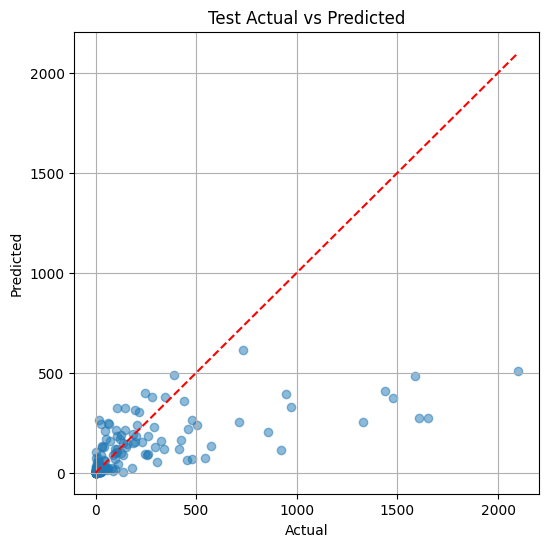

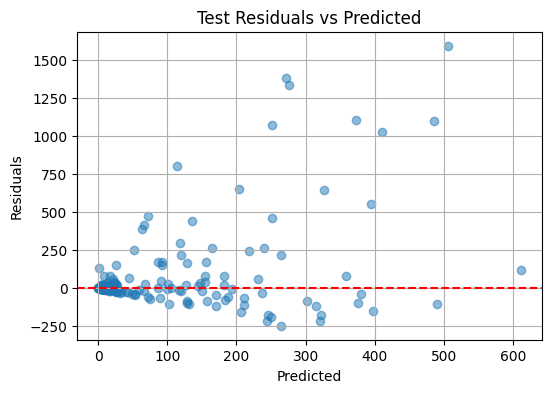

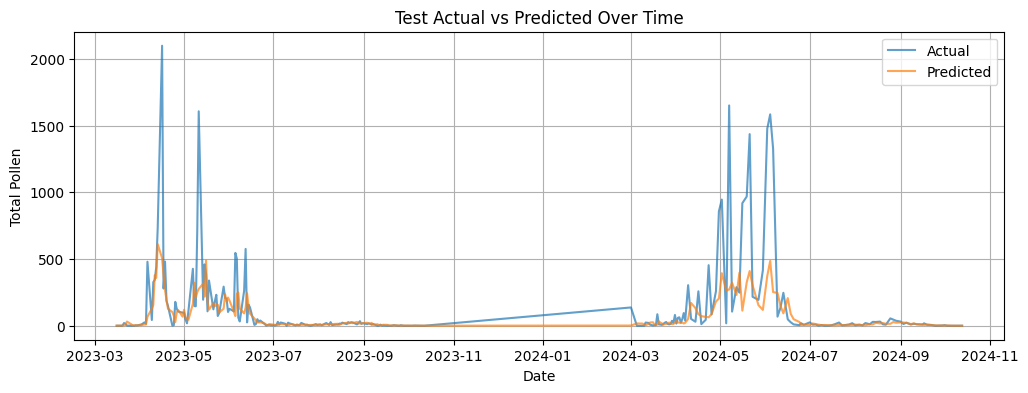

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# --------------------------
## 0. Standardize Columns
# --------------------------
def standardize_columns(df):
    df = df.copy()
    cols = df.columns
    cols = (
        cols.str.strip()
        .str.lower()
        .str.replace('°c','', regex=False)
        .str.replace('°','', regex=False)
        .str.replace('mm','', regex=False)
        .str.replace('/','_', regex=False)
        .str.replace(' ', '_', regex=False)
        .str.replace('(', '', regex=False)
        .str.replace(')', '', regex=False)
        .str.replace('.', '_', regex=False)
    )
    df.columns = cols
    return df

# --------------------------
## 0b. Dummy Data if Needed
# --------------------------
try:
    merged
except NameError:
    dates = pd.date_range('2020-01-01','2023-12-31')
    merged = pd.DataFrame({
        "Date": dates,
        "Total_Pollen": np.exp(np.random.normal(3, 1, len(dates))) * (1 + (dates.month % 12)),
        "temperature_2m_mean": np.random.normal(15,5,len(dates)),
        "relativehumidity_2m_mean": np.random.uniform(30,90,len(dates)),
        "wind_speed_10m_max": np.random.uniform(0,20,len(dates)),
        "precipitation_sum": np.random.uniform(0,10,len(dates)),
        "Numeric_Column_1": np.random.rand(len(dates))
    })

df = standardize_columns(merged)
df['date'] = pd.to_datetime(df['date'])
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# --------------------------
## 1. Feature Engineering
# --------------------------
def make_time_features(df):
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['day_sin'] = np.sin(2*np.pi*df['day_of_year']/365.25)
    df['day_cos'] = np.cos(2*np.pi*df['day_of_year']/365.25)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['weekday_sin'] = np.sin(2*np.pi*df['weekday']/7)
    df['weekday_cos'] = np.cos(2*np.pi*df['weekday']/7)
    return df

def make_lags_rolls(df, target_col='total_pollen', lags=[1,2,3,4,7,14,21,30,365], rolls=[2,3,7,14,30]):
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)

        if lag > 1:
            df[f'lag_{lag}_pct_fixed'] = (df['lag_1'] - df[f'lag_{lag}']) / df[f'lag_{lag}']
        else:
            df[f'lag_{lag}_pct_fixed'] = np.nan

        
    for r in rolls:
        df[f'{target_col}_{r}day'] = df[target_col].shift(1).rolling(r, min_periods=1).mean()
    df['pollen_ratio_1d_7d'] = df['lag_1'] / (df['total_pollen_7day'] + 1e-8)
    return df

def make_weather_features_yesterday(df, weather_cols, rolls=[3,7]):
    """
    Weather features only use data up to yesterday.
    """
    for col in weather_cols:
        if col in df.columns:
            df[f'{col}_yesterday'] = df[col].shift(1)
            for r in rolls:
                df[f'{col}_yesterday_{r}day'] = df[col].shift(1).rolling(r, min_periods=1).mean()
    return df

# Apply feature engineering
df = make_time_features(df)
df = make_lags_rolls(df)
weather_cols = ['temperature_2m_mean','relativehumidity_2m_mean','wind_speed_10m_max','precipitation_sum']
df = make_weather_features_yesterday(df, weather_cols)

# --------------------------
## 1b. Fill Missing Values
# --------------------------
df[numeric_cols] = df[numeric_cols].interpolate().fillna(0)
df = df.dropna(subset=['total_pollen_30day'])

# --------------------------
## 2. Train/Val/Test Split
# --------------------------
df['year'] = df['date'].dt.year
train_df = df[df['year']<2022].copy()
val_df = df[df['year']==2022].copy()
test_df = df[df['year']>=2023].copy()

# --------------------------
## 3. Spike Labeling & Target Transform
# --------------------------
def asinh_transform(x): return np.arcsinh(x)
def asinh_inverse(x): return np.sinh(x)

base_mean = train_df['pollen_ratio_1d_7d'].mean()
base_std = train_df['pollen_ratio_1d_7d'].std(ddof=0)
z_thresh = 1.64

for df_ in [train_df,val_df,test_df]:
    df_['spike_z'] = (df_['pollen_ratio_1d_7d'] - base_mean)/(base_std+1e-8)
    df_['is_spike'] = (df_['spike_z']>z_thresh).astype(int)
    df_['target_asinh'] = asinh_transform(df_['total_pollen'])

# --------------------------
## 4. Feature Selection
# --------------------------
exclude_cols = {
    'date','year','total_pollen','weed','tree','grass', 'ragweed',
    'target_asinh','is_spike','spike_z','pollen_ratio_1d_7d'
}
all_features = [
    c for c in train_df.columns 
    if c not in exclude_cols and train_df[c].dtype in [np.float64, np.int64]
]
all_features = [c for c in all_features if train_df[c].nunique()>1]

X_train, y_train = train_df[all_features], train_df['target_asinh']
X_val, y_val = val_df[all_features], val_df['target_asinh']
X_test, y_test_original = test_df[all_features], test_df['total_pollen']

# --------------------------
## 5. Train Spike Classifier
# --------------------------
clf_params = {
    "n_estimators":5000,
    "learning_rate":0.05,
    "num_leaves":31,
    "min_data_in_leaf":20,
    "feature_fraction":0.8,
    "bagging_fraction":0.8,
    "bagging_freq":5,
    "random_state":42,
    "n_jobs":-1
}

clf = lgb.LGBMClassifier(**clf_params)
clf.fit(
    X_train,
    train_df['is_spike'],
    eval_set=[(X_val, val_df['is_spike'])],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50)]
)

val_spike_prob = clf.predict_proba(X_val)[:,1]
test_spike_prob = clf.predict_proba(X_test)[:,1]
print(f"Classifier val AUC: {roc_auc_score(val_df['is_spike'], val_spike_prob):.3f}")

# --------------------------
## 6. Train Regressors
# --------------------------
reg_params = {
    "n_estimators":3000,
    "learning_rate":0.03,
    "num_leaves":64,
    "min_data_in_leaf":40,
    "lambda_l1":1.0,
    "lambda_l2":1.0,
    "feature_fraction":0.8,
    "bagging_fraction":0.8,
    "bagging_freq":5,
    "random_state":42,
    "n_jobs":-1
}

reg_normal = lgb.LGBMRegressor(**reg_params)
reg_normal.fit(
    X_train[train_df['is_spike']==0],
    y_train[train_df['is_spike']==0],
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50)]
)

reg_spike = lgb.LGBMRegressor(**reg_params)
reg_spike.fit(
    X_train[train_df['is_spike']==1],
    y_train[train_df['is_spike']==1],
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50)]
)

# --------------------------
## 7. Predictions
# --------------------------
pred_normal_test = reg_normal.predict(X_test)
pred_spike_test = reg_spike.predict(X_test)
combined_test_trans = test_spike_prob*pred_spike_test + (1-test_spike_prob)*pred_normal_test
y_pred_test = asinh_inverse(combined_test_trans)

mae = mean_absolute_error(y_test_original, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test))
r2 = r2_score(y_test_original, y_pred_test)
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}, R^2: {r2:.3f}")

# --------------------------
## 8. Feature Importance
# --------------------------
def print_feature_importance(model, model_name):
    importance_df = pd.DataFrame({
        "feature": model.feature_name_,
        "importance": model.feature_importances_
    }).sort_values(by="importance", ascending=False)
    print(f"\nFeature Importance for {model_name}:\n")
    print(importance_df.head(20))
    return importance_df

clf_importance = print_feature_importance(clf, "Spike Classifier")
reg_normal_importance = print_feature_importance(reg_normal, "Normal Regressor")
reg_spike_importance = print_feature_importance(reg_spike, "Spike Regressor")

# --------------------------
## 9. Evaluation Plots
# --------------------------
def plot_model_evaluation(y_true, y_pred, dates=None, title_prefix="Test"):
    # 1. Actual vs Predicted
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title_prefix} Actual vs Predicted")
    plt.grid(True)
    plt.show()
    
    # 2. Residuals vs Predicted
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix} Residuals vs Predicted")
    plt.grid(True)
    plt.show()
    
    # 3. Time Series Plot
    if dates is not None:
        plt.figure(figsize=(12,4))
        plt.plot(dates, y_true, label="Actual", alpha=0.7)
        plt.plot(dates, y_pred, label="Predicted", alpha=0.7)
        plt.xlabel("Date")
        plt.ylabel("Total Pollen")
        plt.title(f"{title_prefix} Actual vs Predicted Over Time")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_model_evaluation(y_test_original, y_pred_test, dates=test_df['date'], title_prefix="Test")
